In [1]:
import os
from typing import Dict, NamedTuple, Union, List, Tuple
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
class Config(NamedTuple):
    data: str = "../dsd_result_raw.csv"
    dirctory: str = "../images/mla"
    savefile: bool = False
    kwarg_savefig: Dict[str, Union[str, int, float]] = {
        "facecolor": "white",
        "dpi": 300,
        "bbox_inches": "tight",
        "pad_inches": 0.05
    }

In [3]:
conf = Config(savefile=True)

In [4]:
os.makedirs(conf.dirctory, exist_ok=True)

In [5]:
# load result data

res = pd.read_csv(conf.data, index_col=0)

In [6]:
res.head(2)

,time,pod,body,wing,width,thickness,fixation,thread,shape
1,8.000,12,2.5,5,8,1,-1,-1,-1
2,5.556,8,2.0,10,6,3,-1,-1,1


In [7]:
def power(
    data: pd.core.frame.DataFrame, 
    dim: int,
    subtract_scale: bool = True,
    name_digit: int = 3
    ) -> pd.core.frame.DataFrame:

    assert isinstance(dim, int) and dim >= 1, \
        f"dim expected non-zero positive int; got {dim}"
    assert isinstance(name_digit, int) and name_digit >= 0, \
        f"name_digit expected positive int; got {name_digit}"

    ret = pd.DataFrame(index=data.index)

    for i in range(dim):
        temp = data ** (i + 1) if not subtract_scale \
            else (data - data.mean()) ** (i + 1)
        if subtract_scale:
            temp.columns = [
                f"({name}-{data.mean()[j].round(name_digit)})" + \
                    f"*({name}-{data.mean()[j].round(name_digit)})" * (i) for j, name in enumerate(temp.columns)
                ]
        else:
            temp.columns = [
                f"{name}" + f"*{name}" * (i) for name in temp.columns
                ]
        ret = pd.concat([ret, temp], axis=1)
    
    return ret

def feat_selector(data: pd.core.frame.DataFrame) -> List[pd.core.frame.DataFrame]:
    ret = []
    for i in range(len(data)):
        l_comb = list(combinations(data.columns, i + 1))
        ret += [data.loc[:, list(comb)] for comb in l_comb]
    return ret


In [8]:
res.head(2)

,time,pod,body,wing,width,thickness,fixation,thread,shape
1,8.000,12,2.5,5,8,1,-1,-1,-1
2,5.556,8,2.0,10,6,3,-1,-1,1


In [9]:
power(res.iloc[:, 1:6], 2, True, 2).head(2)

,(pod-8.0),(body-2.0),(wing-10.0),(width-6.0),(thickness-3.0),(pod-8.0)*(pod-8.0),(body-2.0)*(body-2.0),(wing-10.0)*(wing-10.0),(width-6.0)*(width-6.0),(thickness-3.0)*(thickness-3.0)
1,4.0,0.5,-5.0,2.0,-2.0,16.0,0.25,25.0,4.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [10]:
power(res.iloc[:, 1:], 1, True, 2).head(2)

,(pod-8.0),(body-2.0),(wing-10.0),(width-6.0),(thickness-3.0),(fixation-0.0),(thread-0.0),(shape-0.0)
1,4.0,0.5,-5.0,2.0,-2.0,-1.0,-1.0,-1.0
2,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,1.0


In [11]:
x_df = pd.concat(
    [
        power(res.iloc[:, 1:], 1, True, 2),
        power(res.iloc[:, 1:6], 2, True, 2),
    ],
    axis=1
)

x_df = x_df.loc[:, ~x_df.columns.duplicated()]

In [12]:
x_df.head()

,(pod-8.0),(body-2.0),(wing-10.0),(width-6.0),(thickness-3.0),(fixation-0.0),(thread-0.0),(shape-0.0),(pod-8.0)*(pod-8.0),(body-2.0)*(body-2.0),(wing-10.0)*(wing-10.0),(width-6.0)*(width-6.0),(thickness-3.0)*(thickness-3.0)
1,4.0,0.5,-5.0,2.0,-2.0,-1.0,-1.0,-1.0,16.0,0.25,25.0,4.0,4.0
2,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,1.0,0.0,0.00,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.00,0.0,0.0,0.0
4,4.0,-0.5,5.0,2.0,-2.0,-1.0,-1.0,-1.0,16.0,0.25,25.0,4.0,4.0
5,-4.0,0.5,-5.0,-2.0,0.0,-1.0,-1.0,-1.0,16.0,0.25,25.0,4.0,0.0


In [13]:
df_sep = feat_selector(x_df)

In [14]:
y_df = res.time

In [15]:
l_x = [sm.add_constant(x) for x in df_sep]

l_model = [sm.OLS(y_df, x) for x in l_x]
l_result = [model.fit() for model in l_model]
l_aic = [result.aic for result in l_result]

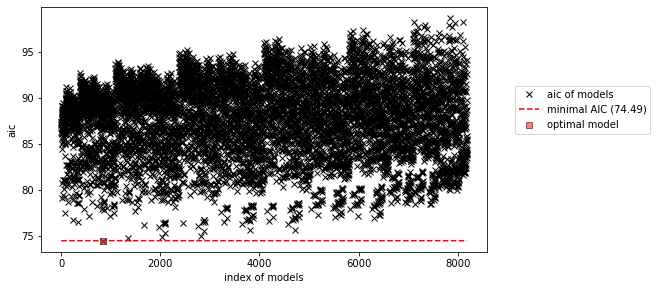

In [16]:
fig, ax = plt.subplots(figsize=(8, 4.5))

ax.plot(
    np.arange(len(l_aic)),
    l_aic, label="aic of models", c="k", marker="x", linewidth=0
)
ax.plot(
    np.arange(len(l_aic)),
    np.array(l_aic).min() * np.ones(len(l_aic)), linestyle="--",
    c="r", label=f"minimal AIC ({np.array(l_aic).min().round(2)})"
)

ax.scatter(
    l_aic.index(min(l_aic)), min(l_aic),
    c="r", marker="s", edgecolor="k", zorder=3, alpha=0.5,
    label="optimal model"
)

ax.set(ylabel="aic", xlabel="index of models")

ax.legend(bbox_to_anchor=(1.05, 0.7));

if conf.savefile:
    plt.savefig(f"{conf.dirctory}/aic.png", **conf.kwarg_savefig)

In [17]:
l_result[l_aic.index(min(l_aic))].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     5.808
Date:                Sun, 17 Oct 2021   Prob (F-statistic):            0.00390
Time:                        21:41:44   Log-Likelihood:                -32.245
No. Observations:                  22   AIC:                             74.49
Df Residuals:                      17   BIC:                             79.94
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       6.5540      0.596     10.996      0.000       5.297       7.811
(wing-10.0)                -0.1044      0.057     -1.837      0.084      -0.224       0.016
(thread-0.0)                0.4918      0.257      1.915      0.072      -0.050       1.034
(shape-0.0)                -0.6160      0.257     -2.399      0.028      -1.158      -0.074
(wing-10.0)*(wing-10.0)    -0.0937      0.026     -3.556      0.002      -0.149      -0.038
==============================================================================
Omnibus:                        7.436   Durbin-Watson:                   1.385
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                5.040
Skew:                           0.974   Prob(JB):                       0.0804
Kurtosis:                       4.304   Cond. No.                         53.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
class variable(NamedTuple):
    name: str
    value: Union[int, float, np.ndarray]

class monovar(NamedTuple):
    x: variable
    y: variable

class binary(NamedTuple):
    x: variable
    y: variable
    z: variable

class multivar():   
    def __init__(
        self,
        expv: List[variable],
        objv: variable
    ):
        self.expv = expv
        self.objv = objv
    
    def pair(self) -> List[binary]:
        l_pair = list(combinations(self.expv, 2))
        return [
            binary(
                x=pair[0],
                y=pair[1],
                z=self.objv
            ) for pair in l_pair
        ]
        

In [19]:
def concat(refernce, array, arrayloc, idx):
    if arrayloc == idx:
        ret_array = np.vstack([
            np.array(
                [v for i in range(len(array.ravel()))]
            ).reshape(array.shape) for v in refernce
        ]).reshape(
            tuple([len(refernce)] + list(array.shape))
        )
    else:
        ret_array = np.vstack(
            [array] * len(refernce)
        ).reshape(
            tuple([len(refernce)] + list(array.shape))
        )
    return ret_array

def multigrid(l_array: List[np.ndarray]):
    dim = len(l_array)
    ret = None
    shape = lambda n, array: (-1, ) if n == 1 \
    else tuple([n] + list(array.shape))
    
    for i in range(dim):
        idx = dim - 1 - i
        if i == 0:
            ret = [
                np.array(
                    [array[0]] * len(l_array[idx])
                ) for array in l_array[:idx]
            ] + [l_array[idx]]
        else:
            ret = [
                concat(
                    l_array[idx], array, j, idx
                ) for j, array in enumerate(ret)
            ]
    return np.vstack(ret).reshape(shape(dim, ret[0]))

In [20]:
def get_func(
    params: pd.core.series.Series,
    data: pd.core.frame.DataFrame,
    isbool: List[bool] = None,
    interval: float = 0.1,
    z_name: str = "Z"
):
    if "const" in params.index:
        idx = params.index[1:]
    else:
        idx = params.index
    
    split_x = lambda l_x: [str(x).split("*") for x in l_x]
    def unique(l_x):
        ret_l_x = [
            l_x[i] for i in sorted(
                np.unique(
                    np.array(l_x),
                    return_index=True
                )[1]
            )
        ]
        return ret_l_x
    get_var = lambda l_x: l_x[0]
    remove_bracket = lambda x: x[1:-1] if "(" in x else x
    split_minus = lambda l_x: [get_var(remove_bracket(x).split("-")) for x in l_x]
    
    l_idx = [split_minus(l_x) for l_x in split_x(idx)]
    l_unique = unique(sum(l_idx, []))

    df_var = data.loc[:, l_unique]
    
    kwd = [
        np.arange(
            df_var[v].min(),
            df_var[v].max(),
            interval
        ) if not isbool[i] else np.array(
            [
                df_var[v].min(),
                df_var[v].max()
            ]
        )for i, v in enumerate(l_unique)
    ]

    xy = multigrid(kwd)

    var = {
        v: xy[i] for i, v in enumerate(l_unique)
    }
    mean = {v: df_var[v].mean() for v in l_unique}

    ret = params[0] if "const" in params.index else 0
    for i, l_var in enumerate(l_idx):
        _ret = 1
        for var_name in l_unique:
            _ret *= (var[var_name] - mean[var_name]) ** l_var.count(var_name)

        idx_coeff = i + 1 if "const" in params.index else i

        ret += params[idx_coeff] * _ret
    
    if len(l_unique) == 1:
        func = monovar(
            x=variable(name=l_unique[0], value=var[l_unique[0]]),
            y=variable(name=z_name, value=ret),
        )
        
    elif len(l_unique) == 2:
        func = binary(
            x=variable(name=l_unique[0], value=var[l_unique[0]]),
            y=variable(name=l_unique[1], value=var[l_unique[1]]),
            z=variable(name=z_name, value=ret),
        )
    else:
        func = multivar(
            expv=[
                variable(
                    name=name, 
                    value=var[name]
                ) for name in l_unique
            ],
            objv=variable(name=z_name, value=ret)
        )
    
    return  func

In [21]:
def contour2d(
    func: binary,
    ax = None,
    level: int = 10,
    digit: int = 1,
    cmap_fill: str = "bone_r",
    cmap_edge: str = "spring",
    **kwarg
    ):
    if ax is None:
        fig, ax = plt.subplots()
    
    x, y, z = func.x.value, func.y.value, func.z.value
    
    if kwarg == {}:
        kwarg = {
            "xlabel": func.x.name,
            "ylabel": func.y.name,
            "title": func.z.name
        }
    
    fill = ax.contourf(x, y, z, levels=level, cmap=cmap_fill)
    edge = ax.contour(
        x, y, z, levels=level,
        cmap=cmap_edge, zorder=2, alpha=1,
    )
    edge.clabel(fmt=f'%.{digit}f')

    ax.set(**kwarg)

In [22]:
def contour3d(
    func: binary,
    ax = None,
    level: int = 10,
    cmap: str = "bone_r",
    **kwarg
    ):
    if ax is None:
        fig, ax = plt.subplots(projection="3d")
    
    x, y, z = func.x.value, func.y.value, func.z.value
    
    if kwarg == {}:
        kwarg = {
            "xlabel": func.x.name,
            "ylabel": func.y.name,
            "zlabel": func.z.name,
            "title": func.z.name
        }
    
    ax.plot_surface(
        x, y, z, cmap=cmap, alpha=1,
        ccount=level, rcount=level, lw=0.1
    )
    
    ax.set(**kwarg)

In [23]:
target = l_result[l_aic.index(min(l_aic))].params

func = get_func(
    target, res, 
    interval=0.01, isbool=[False, True, True],
    z_name="$time$ $[s]$"
)

l_binary = func.pair()
len(l_binary)

3

In [24]:
print(f"""
overview:
$x_1$: {func.expv[0].name}
$x_2$: {func.expv[1].name}
$x_3$: {func.expv[2].name}


max: {func.objv.value.max()}

argmax:
$x_1$: {func.expv[0].value.ravel()[np.argmax(func.objv.value)]}
$x_2$: {func.expv[1].value.ravel()[np.argmax(func.objv.value)]}
$x_3$: {func.expv[2].value.ravel()[np.argmax(func.objv.value)]}


{[f'''
pair{i+1}:
x: {pair.x.name}
y: {pair.y.name}
''' for i, pair in enumerate(l_binary)]} 

""")


overview:
$x_1$: wing
$x_2$: thread
$x_3$: shape


max: 7.690867710868686

argmax:
$x_1$: 9.439999999999905
$x_2$: 1.0
$x_3$: -1.0


['\npair1:\nx: wing\ny: thread\n', '\npair2:\nx: wing\ny: shape\n', '\npair3:\nx: thread\ny: shape\n'] 




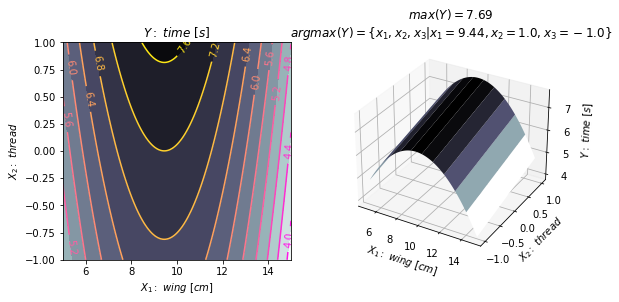

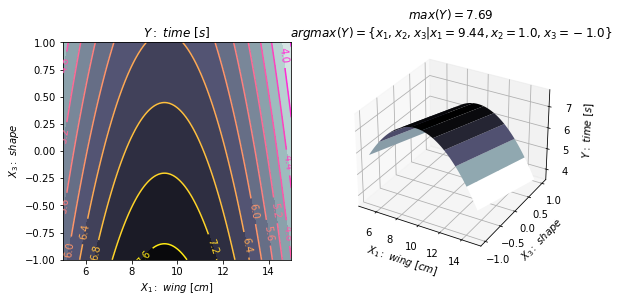

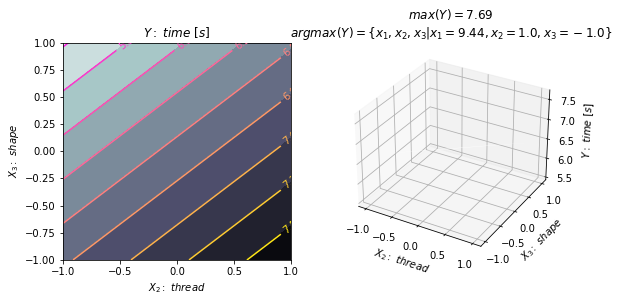

In [27]:
argmax_loc = np.argmax(func.objv.value)
shape = func.objv.value.shape

for i, bin_func in enumerate(l_binary):
    
    fig = plt.figure(figsize=(9, 4))

    ax1 = fig.add_subplot(121, facecolor="w")
    ax2 = fig.add_subplot(122, projection="3d", facecolor="w")



    arg2d = {
        "xlabel": "$X_"+ f"{[1, 1, 2][i]}:$ $" + f"{bin_func.x.name}$" + \
        [" $[cm]$", " $[cm]$", ""][i],
        "ylabel": "$X_"+ f"{[2, 3, 3][i]}:$ $" + f"{bin_func.y.name}$",
        "title": "$Y:$ " + f"{bin_func.z.name}",
    }

    title = "$max(Y)=" + f"{func.objv.value.max().round(2)}$\n" +\
    "$argmax(Y)=\{x_1, x_2, x_3|" + \
    f"x_1={func.expv[0].value.ravel()[argmax_loc].round(2)}," +\
    f"x_2={func.expv[1].value.ravel()[argmax_loc].round(2)}," +\
    f" x_3={func.expv[2].value.ravel()[argmax_loc].round(2)}" + "\}$"

    arg3d = {
        "xlabel": "$X_"+ f"{[1, 1, 2][i]}:$ $" + f"{bin_func.x.name}$" + \
        [" $[cm]$", " $[cm]$", ""][i],
        "ylabel": "$X_"+ f"{[2, 3, 3][i]}:$ $" + f"{bin_func.y.name}$",
        "zlabel": "$Y:$ " + f"{bin_func.z.name}",
        "title": title
    }
    
    temp = [
        binary(
            x=variable(
                name=bin_func.x.name, 
                value=bin_func.x.value[
                    :, :, argmax_loc//(shape[0]*shape[1])
                ]
            ),
            y=variable(
                name=bin_func.y.name, 
                value=bin_func.y.value[
                    :, :,  argmax_loc//(shape[0]*shape[1])
                ]
            ),
            z=variable(
                name=bin_func.z.name, 
                value=bin_func.z.value[
                    :, :,  argmax_loc//(shape[0]*shape[1])
                ]
            ),
        ),
        binary(
            x=variable(
                name=bin_func.x.name, 
                value=bin_func.x.value[
                    :, (argmax_loc // shape[0]) % shape[2], :
                ]
            ),
            y=variable(
                name=bin_func.y.name, 
                value=bin_func.y.value[
                    :, (argmax_loc // shape[0]) % shape[2], :
                ]
            ),
            z=variable(
                name=bin_func.z.name, 
                value=bin_func.z.value[
                    :, (argmax_loc // shape[0]) % shape[2], :
                ]
            ),
        ),
        binary(
            x=variable(
                name=bin_func.x.name, 
                value=bin_func.x.value[
                     argmax_loc//(shape[1]*shape[2]), :, :
                ]
            ),
            y=variable(
                name=bin_func.y.name, 
                value=bin_func.y.value[
                    argmax_loc//(shape[1]*shape[2]), :, :
                ]
            ),
            z=variable(
                name=bin_func.z.name, 
                value=bin_func.z.value[
                    argmax_loc//(shape[1]*shape[2]), :, :
                ]
            ),
        ),
    ][i]

    contour2d(temp, ax=ax1, **arg2d)
    contour3d(temp, ax=ax2, **arg3d)

    if conf.savefile:
        plt.savefig(f"{conf.dirctory}/optimization_{i+1}.png", **conf.kwarg_savefig)